(gen-ref)=
# Referenzdatensatz generieren

:::{admonition} **Lernziele**
- Referenzdaten generieren
- mithilfe von Annahmen und bestehenden Datensätzen
- um den Istzustand zu analysieren und Veränderungen zu vergleichen
:::

## python konfigurieren

### Module importieren

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import shutil

print('Versionen der verwendeten python-Module: ')
print('numpy', np.__version__)
print('matplotlib', matplotlib.__version__)
print('pandas', pd.__version__)
print('datetime', dt)
print('os', os)
print('shutil', shutil)

Versionen der verwendeten python-Module: 
numpy 2.1.1
matplotlib 3.9.2
pandas 2.2.3
datetime <module 'datetime' from '/home/franzi/.pyenv/versions/miniconda3-latest/lib/python3.12/datetime.py'>
os <module 'os' (frozen)>
shutil <module 'shutil' from '/home/franzi/.pyenv/versions/miniconda3-latest/lib/python3.12/shutil.py'>


### Grafikparameter einstellen

In [2]:
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 18
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
if shutil.which('latex'): plt.rcParams['text.usetex'] = True

### Funktionen definieren

In [3]:
def read_energy_logger_file(path_to_file):

    # Check if path exists
    if not os.path.exists(path_to_file) or not os.path.isfile(path_to_file):
        raise Exception("No file at given path!")
        
    # Read data into pandas dataframe
    df = pd.read_csv(path_to_file, header=7)

    # Rename columns
    df = df.rename(columns = {"Aufnahmezeit": "timestamp", "Stromstärke (A)": "Current [A]", "Wirkleistung (W)": "Active Power [W]", "Scheinleistung (W)": "Apparent Power [VA]"})

    # Since the data provided by the energy logger
    # is not formated correctly for further usage,
    # each cell needs to be reformated.

    # Format columns
    for column in df.columns:
        if not column =="timestamp":

        # Get string from column,
            df[column] = df[column].str.replace(",", ".").astype({column: 'float64'})
            
    # Store datetime object in timestamp
    df["timestamp"] = df["timestamp"].apply(lambda x: dt.datetime.strptime(x, "%d-%m-%Y %H:%M:%S"))

    return df

## Mathematische Möglichkeiten zur Beschreibung von Datensätzen

Ein Lastprofil ist ein Zeitreihenmodell {cite:p}`schellong_modellierung_2000`.

**Saisonale Variation** $S(t)$: Hier beschreibt man z. B. mit einem temperatur- oder lichtabhängigen Faktor, dass sich bestimmte Bedarfe erhöhen oder verringern.

**Trends** $T(t)$ erhält man, indem man Mittelwerte über größere Zeiträume bildet und so z. B. herausfindet, ob der Energiebedarf für bestimmte Aktivitäten/Prozesse oder auch für alles zusammen im Betrachtungszeitraum gestiegen oder gesunken ist. Modelliert man einen Trend, so legt man, ähnlich wie bei der Modellierung der saisonalen Variation einen entsprechenden Faktor an, mit dem bestimmte oder alle Bedarfe erhöht oder verringert werden.

**Überjährige zyklische Komponenten** $C(t)$ sind z. B. Effekte wie Urlaub oder Weihnachtsferien, die immer wieder auftreten, zyklisch sich wiederholen, aber auch z. B. die Unterscheidung zwischen Wochenende und Wochentag.

**Ausreißer** $R(t)$ treten häufig bei singulären Ereignissen auf, z. B. sinkt der Energiebedarf in bestimmten Produktionsbetrieben während der Fußballweltmeisterschaft-Endspiele (und erhöht sich dafür in Haushalten).

Die beschriebenen Komponenten lassen sich addieren für ein **additives Zeitreihenmodell**: 
\begin{equation}
y(t) = T(t) + S(t) + C(t) + R(t)
\end{equation}

Alternativ lassen sich **hybride Zeitreihenmodelle** nutzen:
\begin{equation}
y(t) = T(t)\cdot S(t) + R(t)
\end{equation}

Es ist nicht eins der Modelle besser oder schlechter als das andere, sondern es hängt davon ab, was Sie modellieren wollen und dann eignen sich die verschiedenen Modelle unterschiedlich gut.

## Referenz-Datensatz aus Einzelgerätemessungen und Annahmen erstellen

Das Beispiel hier ist sehr einfach gehalten. Es soll hier um die Vorgehensweise gehen. Zwei Beispielgeräte mit definiertem Verhalten bestimmen den Datensatz. Außerdem kommt bei einem der Geräte eine definierte Standby-Leistung vor.

### Nutzungszeiten im Beispiel

Das erste Gerät wird um 09:00 und um 11:30 Uhr vom 01.04.2020 für einige Tage vom Beispielnutzer eingesetzt. Die ganze Zeit ist Standbyleistung nötig. Beim zweiten Gerät findet die Nutzung um 09:30 statt und es fällt durch Trennen des Stromkreises keine Standbyleistung an. 

In [4]:
starting = "01-04-2020 00:00:00"
start_date = dt.datetime.strptime(starting, "%d-%m-%Y %H:%M:%S")
no_days = 3 # number of days
duration = 24*60*no_days # minutes in a day during no_days
time_of_use1 = 9
time_of_use2 = 11.5
time_of_use3 = 9.5

### Einzelgerätemessungen

Das erste Beispielgerät hat im Betrieb das gemessene Lastprofil in der Datei `../data/Energieloggertestdaten.csv`, das zweite findet sich in `../data/Energieloggertestdaten2.csv`. Das Notebook [SYE-data](http://oer4renewables.gitlab.io/systemtechnik-fuer-energieeffizienz/04/SYE-data.html) beschreibt das Einlesen der Daten.

In [5]:
examplemeas = read_energy_logger_file('../data/Energieloggertestdaten.csv')
examplemeas2 = read_energy_logger_file('../data/Energieloggertestdaten2.csv')

### Angenommener Standbyverbrauch

Aus dem Beispieldatenblatt geht ein Standbyverbrauch von 2 Watt für Gerät 1 hervor, der sich mit dem Energielogger nicht zuverlässig messen lässt. Derjenige niedrigste Messwert ist diesem Wert am nächsten. Daher schätzt der folgende Code den Leistungsfaktor im Standby als gleich groß wie den Leistungsfaktor beim niedrigsten Messwert.

In [6]:
voltage = 230 # Volt
examplestandby = 2 # Watt
examplepowerfactor = examplemeas['Active Power [W]'].min()/examplemeas['Apparent Power [VA]'].min()
examplestandbycurrent = examplestandby/(voltage*examplepowerfactor)
examplestandbyapparentpower = voltage*examplestandbycurrent

### Zusammenfügen der Messungen zu den gewünschten Zeiten und des Standbyverbrauchs zu den restlichen Zeiten für Gerät 1

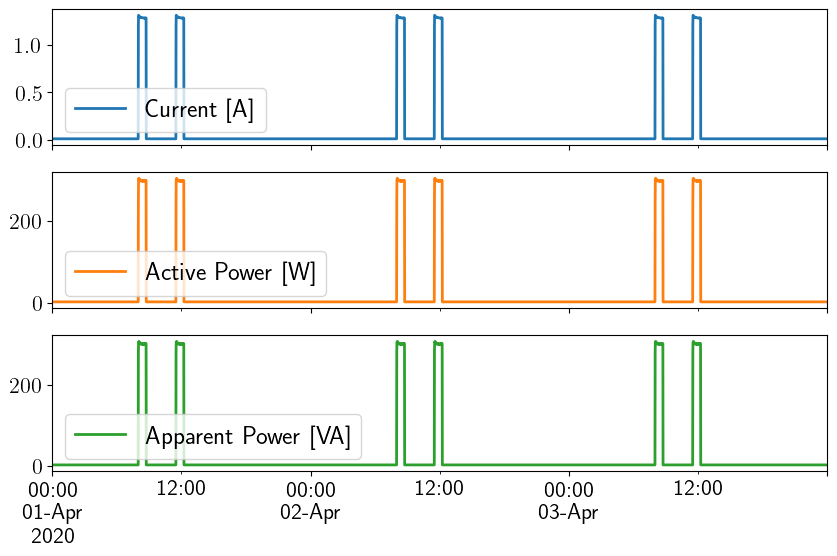

In [7]:
time = pd.date_range(start_date, periods = duration, freq = "60s")
exampledata = pd.DataFrame(0.0, index = time, columns = ['Current [A]', 'Active Power [W]', 'Apparent Power [VA]'])
for x in range(no_days):
    tmp_date = start_date + dt.timedelta(days = x, hours = time_of_use1)
    for y in range(len(examplemeas)):
        exampledata.at[tmp_date + dt.timedelta(minutes = y), 'Current [A]'] += examplemeas['Current [A]'][y]
        exampledata.at[tmp_date + dt.timedelta(minutes = y), 'Active Power [W]'] += examplemeas['Active Power [W]'][y]
        exampledata.at[tmp_date + dt.timedelta(minutes = y), 'Apparent Power [VA]'] += examplemeas['Apparent Power [VA]'][y]
for x in range(no_days):
    tmp_date = start_date + dt.timedelta(days = x, hours = time_of_use2)
    for y in range(len(examplemeas)):
        exampledata.at[tmp_date + dt.timedelta(minutes = y), 'Current [A]'] += examplemeas['Current [A]'][y]
        exampledata.at[tmp_date + dt.timedelta(minutes = y), 'Active Power [W]'] += examplemeas['Active Power [W]'][y]
        exampledata.at[tmp_date + dt.timedelta(minutes = y), 'Apparent Power [VA]'] += examplemeas['Apparent Power [VA]'][y]
exampledata.replace(0, np.nan, inplace=True)
exampledata.fillna({'Current [A]': examplestandbycurrent,'Active Power [W]': examplestandby, 'Apparent Power [VA]': examplestandbyapparentpower}, inplace=True)
exampledata.plot(subplots = True)
plt.show()

### Zeitliche Varianz einbauen bei der genauen Startzeit

Es ist reichlich unwahrscheinlich, dass ein Gerät immer um Punkt 9 Uhr und um Punkt 11:30 angeschaltet wird und dies an allen Tagen des Jahres - falls es manuell erfolgt. Das bedeutet, dass man für die Startzeit noch eine Varianz hinterlegen sollte:

In [8]:
examplevariablestart = pd.DataFrame(0.0, index = time, columns = ['Current [A]', 'Active Power [W]', 'Apparent Power [VA]'])
for x in range(no_days):
    tmp_date = start_date + dt.timedelta(days = x, hours = time_of_use1, minutes = np.random.randint(60))
    for y in range(len(examplemeas)):
        examplevariablestart.at[tmp_date + dt.timedelta(minutes = y), 'Current [A]'] += examplemeas['Current [A]'][y]
        examplevariablestart.at[tmp_date + dt.timedelta(minutes = y), 'Active Power [W]'] += examplemeas['Active Power [W]'][y]
        examplevariablestart.at[tmp_date + dt.timedelta(minutes = y), 'Apparent Power [VA]'] += examplemeas['Apparent Power [VA]'][y]
for x in range(no_days):
    tmp_date = start_date + dt.timedelta(days = x, hours = time_of_use2, minutes = np.random.randint(60))
    for y in range(len(examplemeas)):
        examplevariablestart.at[tmp_date + dt.timedelta(minutes = y), 'Current [A]'] += examplemeas['Current [A]'][y]
        examplevariablestart.at[tmp_date + dt.timedelta(minutes = y), 'Active Power [W]'] += examplemeas['Active Power [W]'][y]
        examplevariablestart.at[tmp_date + dt.timedelta(minutes = y), 'Apparent Power [VA]'] += examplemeas['Apparent Power [VA]'][y]
examplevariablestart.replace(0, np.nan, inplace=True)
examplevariablestart.fillna({'Current [A]': examplestandbycurrent,'Active Power [W]': examplestandby, 'Apparent Power [VA]': examplestandbyapparentpower}, inplace=True)
examplevariablestart.plot(subplots = True)
plt.show()

Außerdem ist für längere Lastprofile z. B. noch wichtig, Urlaubszeiten, jahreszeitliche Schwankungen etc. zu hinterlegen. Dies findet hier nicht statt.

### Verhalten des zweiten Gerätes ergänzen

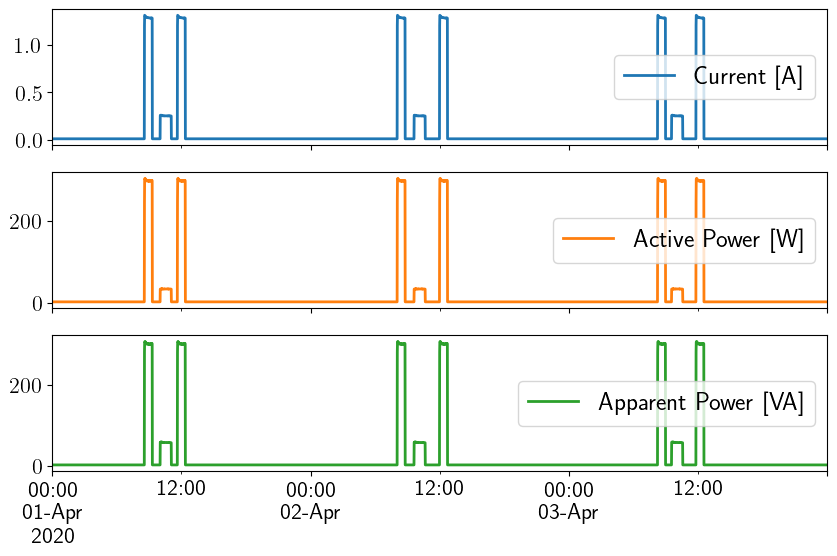

In [9]:
examplefull = examplevariablestart
for x in range(no_days):
    tmp_date = start_date + dt.timedelta(days = x, hours = time_of_use3, minutes = np.random.randint(60))
    for y in range(len(examplemeas2)):
        examplefull.at[tmp_date + dt.timedelta(minutes = y), 'Current [A]'] += examplemeas2['Current [A]'][y]
        examplefull.at[tmp_date + dt.timedelta(minutes = y), 'Active Power [W]'] += examplemeas2['Active Power [W]'][y]
        examplefull.at[tmp_date + dt.timedelta(minutes = y), 'Apparent Power [VA]'] += examplemeas2['Apparent Power [VA]'][y]
examplefull.plot(subplots = True)
plt.show()

Auf diese Weise lässt sich aus Einzelmessungen ein zusammengesetztes Lastprofil erstellen, das als Referenz dient für die Bewertung von Energieeffizienzmaßnahmen, die ebenfalls simuliert werden können.

:::{bibliography}
:filter: docname in docnames
:::